Character learning has two components.  First, we need to learn the structure of the automaton representing the automaton.  ProbFOIL, a relational learning library built on top of ProbLog, seems a natural choice---at any rate, it remains for future work.

Once we have a structure, we can fit parameters to that structure.  Example parameters include the dynamics of each state and any parameters on guards.  Since we only consider one character at a time, we can abstract the environment into occluding collisions, non-occluding collisions, and hostile collisions.

We'll work with non-hierarchical, non-concurrent hybrid automata for now.  Also, we'll assume left and right movement are mirrored.  Our representation of a state will define, for each variable, whether it has a constant velocity or a constant acceleration (and what that value is); and what transitions are available under what circumstances (a conjunction of abstracted inputs, continuous variable thresholds, timers, any collisions of any type at any normal to the character, and negations of the same).  A state machine is a set of states and an initial state.

In [2]:
%matplotlib inline

import pymc3 as pm

import matplotlib.pyplot as plt
import seaborn as sns
#from ipywidgets import interactive, fixed

import numpy as np
import pandas as pd


import theano

import jumpfinder
from jumpfinder import hold, marioGetX, marioGetY, metroidGetX, metroidGetY
import fceulib

/Users/jcosborn/.virtualenvs/mechlearn/lib/python2.7/site-packages/matplotlib/__init__.py:1357: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [3]:
RIGHT = 1 << 7
LEFT = 1 << 6
DOWN = 1 << 5
UP = 1 << 4
START = 1 << 3
SELECT = 1 << 2
B = 1 << 1
A = 1 << 0

mario_x = 0x006D
mario_y = 0x00CE

metroid_x = 0x0051
metroid_y = 0x0052

In [4]:
jumpButton = A
games = {
    "mario": (
        "mario.nes",
        (hold(0x0, 120) + hold(START | jumpButton, 30) +
         hold(0x0, 150)),
        marioGetX,
        marioGetY
    ),
    "metroid": (
        "metroid.nes",
        (hold(0x0, 60) + hold(START, 1) + hold(0x0, 15) +
         hold(START, 1) + hold(0x0, 600) + hold(LEFT, 400) +
         hold(RIGHT, 30)),
        metroidGetX,
        metroidGetY
    )
}
# CHANGE GAME HERE
(game, startInputs, getx, gety) = games["metroid"]
total = 0
emu = fceulib.runGame(game)
for m in startInputs:
    total = total + 1
    emu.step(m, 0x0)

emu.step(0x0, 0x0)
start = fceulib.VectorBytes()
emu.save(start)
trials = jumpfinder.runTrials(emu, start, getx, gety, jumpButton)

Let's learn three linear-or-constant velocity models.

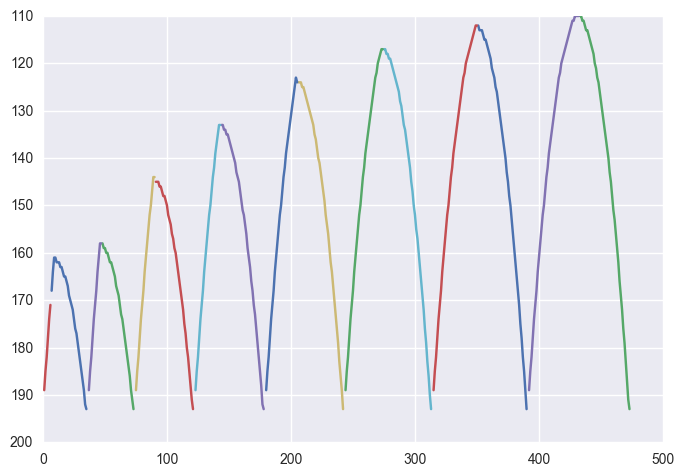

In [10]:
mode_names = ["ground", "rise", "fall"]
modes = dict()
for m in mode_names:
    modes[m] = []

def record_run(modes, state, t, vbls):
    frame = pd.DataFrame(vbls)
    modes[state].append((t, frame))

t = 0
state_change_t = 0
# Tweak the range and increment to get more precise/slower fitting.
for moves, stats in trials[5:-1:5]:
    state = "ground"
    vbls = dict(x=[stats.x.allVals[0]],
                y=[stats.y.allVals[0]],
                dx=[0],
                dy=[0],
                t=[t-state_change_t])
    # print "Move count:"+str(len(moves))
    for i, m in enumerate(moves):
        t += 1
        if state == "ground" and m & jumpButton:
            #print "Jumping, record ground->rise at "+str(state_change_t)+" :"+str(vbls["y"])
            record_run(modes, state, state_change_t, vbls)
            state_change_t = t
            vbls["x"] = []
            vbls["y"] = []
            vbls["dx"] = []
            vbls["dy"] = []
            vbls["t"] = []
            state = "rise"
        elif state == "rise" and not (m & jumpButton):
            #print "Jumping, record rise->fall at "+str(state_change_t)+" :"+str(vbls["y"])
            record_run(modes, state, state_change_t, vbls)
            state_change_t = t
            vbls["x"] = []
            vbls["y"] = []
            vbls["dx"] = []
            vbls["dy"] = []
            vbls["t"] = []
            state = "fall"
        vbls["x"].append(stats.x.allVals[i+1])
        vbls["y"].append(stats.y.allVals[i+1])
        vbls["dx"].append(stats.x.allVals[i+1] - stats.x.allVals[i])
        vbls["dy"].append(stats.y.allVals[i+1] - stats.y.allVals[i])
        vbls["t"].append(t-state_change_t)
    #print "Landed, record "+state+"->ground "+str(vbls["y"])+" at "+str(state_change_t)
    record_run(modes, state, state_change_t, vbls)
    t += 1
    state_change_t = t
    

for m in modes:
    #print m
    for (run_start, run_vbls) in modes[m]:
        #print str(run_start)+".."+str(run_start+len(run_vbls["y"]))
        plt.plot(run_vbls["t"]+run_start, run_vbls["y"])


plt.gca().invert_yaxis()
plt.show()


In [7]:
with pm.Model() as model:
    accs = dict()
    dy0s = dict()
    run_params = dict()
    for m in modes:
        # This is totally just from modifying existing linear regression code for pymc3
        # I'm using one acc per mode and one initial DY per mode, but really the DY should
        #  be per transition INTO the mode, i.e. mode->mode pair/transition ID.
        # One initial DY per trial grew my model too quickly, so I think it's fine to interpret
        #  noisy or uncertain DY0 values as "no discrete velocity update".

        # Also TODO: learn one acc per variable, not just y.  I can assume all velocities
        #  are dependent on time. 
        accs[m] = pm.Normal(m+"_yacc",0,sd=20)
        dy0s[m] = pm.Normal(m+"_dy0",0,sd=20)
        # Store the params for each trial in case I need them later.
        run_params[m] = []
        for (start, vbls) in modes[m]:
            # I'm not sure whether it's OK to learn one sigma per mode or one per trial.
            #  When I learned one per mode, I encountered an error about nonsense values...
            #  But that may have been unrelated?
            sig = pm.HalfCauchy(m+"_"+str(start)+"_dysig",beta=10,testval=1.)
            # Here's the velocity line fitting proper.
            lik = pm.Normal(m+"_"+str(start)+"_dy", mu=dy0s[m]+accs[m]*vbls["t"], sd=sig, observed=vbls["dy"])
            run_params[m].append((start,sig,dy0s[m],lik,vbls))
    print "Find start"
    start = dict()
    # MAP supposedly doesn't always give good estimates, plus it takes a long time.
    # The sample code used it plus NUTS, but I think metropolis without any hints does fine.
    #start = pm.find_MAP()
    print str(start)
    print "Set up step method"
    step = pm.Metropolis()
    #step = pm.NUTS(scaling=start)
    print "Start sampling"
    trace = pm.sample(2000, step, progressbar=True)
    print "Done!"


Start sampling


Find start
{}
Set up step method


Applied log-transform to ground_391_dysig and added transformed ground_391_dysig_log_ to model.


Applied log-transform to ground_314_dysig and added transformed ground_314_dysig_log_ to model.


Applied log-transform to ground_243_dysig and added transformed ground_243_dysig_log_ to model.


Applied log-transform to ground_179_dysig and added transformed ground_179_dysig_log_ to model.


Applied log-transform to ground_122_dysig and added transformed ground_122_dysig_log_ to model.


Applied log-transform to ground_74_dysig and added transformed ground_74_dysig_log_ to model.


Applied log-transform to ground_36_dysig and added transformed ground_36_dysig_log_ to model.


Applied log-transform to ground_0_dysig and added transformed ground_0_dysig_log_ to model.


Applied log-transform to rise_392_dysig and added transformed rise_392_dysig_log_ to model.


Applied log-transform to rise_315_dysig and added transformed rise_315_dysig_log_ to model.


Applied log-transform to rise_244_dysig and added transformed rise_244_dysig_log_ to model.


Applied log-transform to rise_180_dysig and added transformed rise_180_dysig_log_ to model.


Applied log-transform to rise_123_dysig and added transformed rise_123_dysig_log_ to model.


Applied log-transform to rise_75_dysig and added transformed rise_75_dysig_log_ to model.


Applied log-transform to rise_37_dysig and added transformed rise_37_dysig_log_ to model.


Applied log-transform to rise_1_dysig and added transformed rise_1_dysig_log_ to model.


Applied log-transform to fall_433_dysig and added transformed fall_433_dysig_log_ to model.


Applied log-transform to fall_351_dysig and added transformed fall_351_dysig_log_ to model.


Applied log-transform to fall_275_dysig and added transformed fall_275_dysig_log_ to model.


Applied log-transform to fall_206_dysig and added transformed fall_206_dysig_log_ to model.


Applied log-transform to fall_144_dysig and added transformed fall_144_dysig_log_ to model.


Applied log-transform to fall_91_dysig and added transformed fall_91_dysig_log_ to model.


Applied log-transform to fall_48_dysig and added transformed fall_48_dysig_log_ to model.


Applied log-transform to fall_7_dysig and added transformed fall_7_dysig_log_ to model.


In [8]:
pm.stats.summary(trace)


fall_yacc:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.084            0.018            0.002            [0.034, 0.097]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.034          0.084          0.091          0.093          0.098


fall_dy0:

  Mean             SD               MC Error         95% HPD interval
  -------------------------------------------------------------------
  
  0.345            0.330            0.032            [0.067, 1.119]

  Posterior quantiles:
  2.5            25             50             75             97.5
  |--------------|==============|==============|--------------|
  
  0.077          0.173          0.219          0.344          1.241


rise_yacc:

  Mean             SD               MC Error         95% HPD interval
  --------------

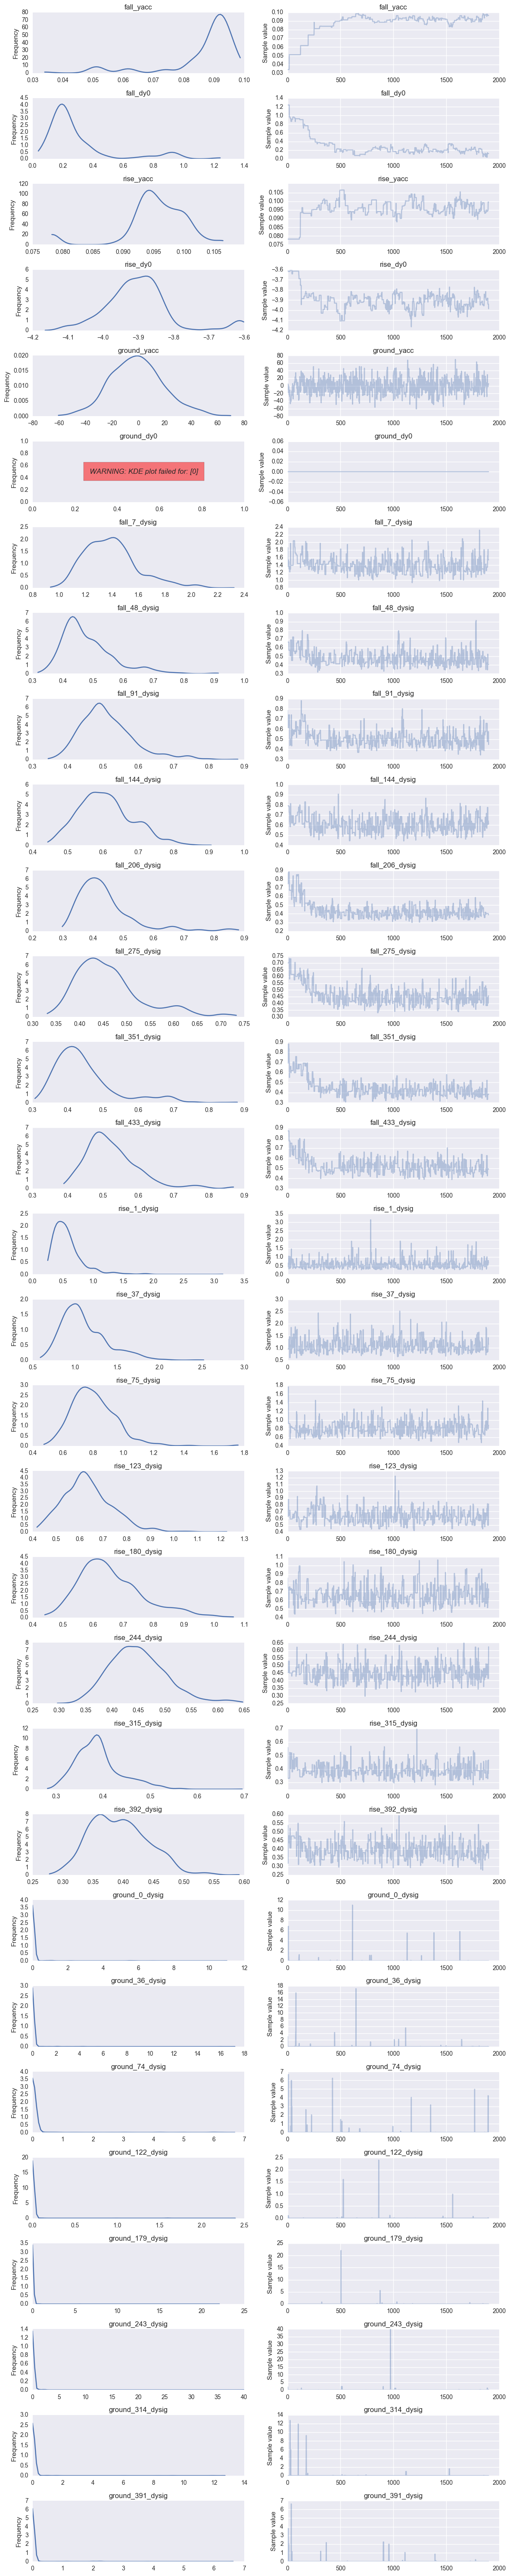

In [9]:
plt.figure(figsize=(6, 6))
pm.traceplot(trace[100:])
plt.tight_layout();

In [0]:
#pm.glm.plot_posterior_predictive(trace, eval=data["rx"], samples=100, label='posterior predictive regression lines')
#plt.plot(data["rx"], data["ry"])

In [0]:
# modelnm = "M"
# datamodelnm = "M"
# npoints = 100
# xc = "t"
# yc = "dy"
# mdl = model
# trc = pm.trace_to_dataframe(trace[-1000:])
# trc = trc[[xc,yc]]

# ordr = 1
# xlims = (0, t)

# x = np.linspace(xlims[0], xlims[1], npoints).reshape((npoints,1))
# pwrs = np.ones((npoints,ordr+1)) * np.arange(ordr+1)
# X = x ** pwrs
# cr = np.dot(X,trc.T)

# ## Calculate credible regions and plot over the datapoints
# dfp = pd.DataFrame(np.percentile(cr,[2.5, 25, 50, 75, 97.5], axis=1).T,
#                    columns=['025','250','500','750','975'])
# dfp['x'] = x

# pal = sns.color_palette('Greens')

# f, ax1d = plt.subplots(1,1, figsize=(7,7))
# f.suptitle('Posterior Predictive Fit -- Data: {} -- Model: {}'.format(
#     datamodelnm, modelnm), fontsize=16)
# plt.subplots_adjust(top=0.95)
# ax1d.fill_between(dfp['x'], dfp['025'], dfp['975'], alpha=0.5
#                   ,color=pal[1], label='CR 95%')
# ax1d.fill_between(dfp['x'], dfp['250'], dfp['750'], alpha=0.5
#                   ,color=pal[2], label='CR 50%')
# ax1d.plot(dfp['x'], dfp['500'], alpha=0.6, color=pal[4], label='Median')
# _ = plt.legend()
# _ = ax1d.set_xlim(xlims)
# _ = sns.regplot(x=xc, y=yc, data=data, fit_reg=False
#                 ,scatter_kws={'alpha':0.7,'s':100, 'lw':2,'edgecolor':'w'}, ax=ax1d)


In [0]:
pm.stats.dic(model=model,trace=trace)
